In [2]:
# Install the latest version of PyTorch and torch-vision, then install the fvcore library that contains a collection of PyTorch Functions. This was developed by Facebook research.
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-aflkr19s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-aflkr19s
  Resolved https://github.com/facebookresearch/fvcore.git to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65405 sha256=e58b2995a84dd867212f0593ffc74eff81f72d28b66ed351dd2521a877f62994
  Stored in directory: /tmp/pip-ephem-wheel-cache-8j52oq_e/wheels/1a/ae/26/d93adc5470e3323d9144ccbcb7b8be77f040ec5087c3839d70
Successfully built fvcore
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.5.post20221221
    Uninstalling fvcore-0.1.5.post20221221

'1.13.1+cu116'

In [3]:
# Clone the Detectron2  From Facebook Research GitHub
# Detectron2 is a popular computer vision library that was built with PyTorch. This library can be utilized for a plethora of tasks such as Object Detection, Segmentation, etc.
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.6
    Uninstalling fvcore-0.1.6:
      Successfully uninstalled fvcore-0.1.6
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [1]:
# The runtime may need to be restarted so that the installation take will take effect
# Some basic setup
# Setting up Detectron2 Logger which is the logging system for the library
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import Common Libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Import Some Detectron2 Utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
# Clone the TACO repo
!git clone https://github.com/pedropro/TACO

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 740 (delta 116), reused 132 (delta 89), pack-reused 580
Receiving objects: 100% (740/740), 98.85 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (493/493), done.


In [3]:
# Move the folder that contains the JSON annotations to Home
!cp -r TACO/data .

In [4]:
# Download The Taco Dataset Images 
!python TACO/download.py

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished


In [5]:
#os is used to intreact with the operating system
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
# The downloaded dataset had an error where the annotations of IDs were repeated
# The following code block identifies which IDs were repeated and how many times they were repeated
import json
  
# Opening JSON file
f = open('data/annotations.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list

ids = {}

for i in data["annotations"]:
    if i["id"] in ids.keys():
      ids[i["id"]] = ids[i["id"]] + 1
    else:
      ids[i["id"]] = 1

for i in ids:
  if ids[i] > 1:

    print("ID: ", i, "Number of times repeated: ", ids[i])

ID:  309 Number of times repeated:  2
ID:  4040 Number of times repeated:  2


In [7]:
# Resgister the dataset 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("taco_dataset_v4", {}, "data/new_annotations.json", "data")

In [8]:
# To combat this issue we selected the IDs that were repeated in the dataset and assigned that ID with a random number between 10,000 & 1,000,000.
# Now the IDs of the annotation were random numbers and did not interfere with anything else.
import random

for i in data["annotations"]:
    if i["id"] in [309, 4040]:
       i["id"] = random.randrange(10000, 1000000, 1)
with open('data/new_annotations.json', 'w') as f:
    json.dump(data, f)

In [10]:
#Section Model Training
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

#Initializes the new congifuatin object. cfg is used to store various settings, hyperparameters which control the model during training.
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("taco_dataset_v4",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  

# Processes Two Images In Each Batch
cfg.SOLVER.IMS_PER_BATCH = 2

# The Base Learning Rate 
cfg.SOLVER.BASE_LR = 0.00025

#The number of Epochs or Maximum Number of Iterations
cfg.SOLVER.MAX_ITER = 7500

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 60  

# This part of the code creates a directory in the cfg config file and stores the output training. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#This is responsible for training the model
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/09 00:16:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/09 00:16:56 d2.engine.train_loop]: Starting training from iteration 0
[03/09 00:17:14 d2.utils.events]:  eta: 1:45:55  iter: 19  total_loss: 5.84  loss_cls: 4.212  loss_box_reg: 0.6858  loss_mask: 0.6934  loss_rpn_cls: 0.05952  loss_rpn_loc: 0.01706  time: 0.8530  last_time: 0.9637  data_time: 0.2016  last_data_time: 0.0275   lr: 4.9953e-06  max_mem: 3185M
[03/09 00:17:35 d2.utils.events]:  eta: 1:53:30  iter: 39  total_loss: 5.739  loss_cls: 4.098  loss_box_reg: 0.7666  loss_mask: 0.6934  loss_rpn_cls: 0.06616  loss_rpn_loc: 0.02166  time: 0.9426  last_time: 0.9197  data_time: 0.2491  last_data_time: 0.2276   lr: 9.9902e-06  max_mem: 3274M
[03/09 00:17:53 d2.utils.events]:  eta: 1:50:27  iter: 59  total_loss: 5.416  loss_cls: 3.748  loss_box_reg: 0.7848  loss_mask: 0.6921  loss_rpn_cls: 0.09634  loss_rpn_loc: 0.02081  time: 0.9300  last_time: 0.9601  data_time: 0.1979  last_data_time: 0.0790   lr: 1.4985e-05  max_mem: 3274M
[03/09 00:18:13 d2.utils.events]:  eta: 1:49:08  iter: 79

In [17]:
#Setting the path for the pre trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#Setting a threshold for object detection. Thus when the model scans an image it would return predictions with a score of 0.5 or above. 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

#Define the dataset within the cfg configuration file
cfg.DATASETS.TEST = ("taco_dataset_v4", )

#Generate predictions
predictor = DefaultPredictor(cfg)

[03/09 02:19:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [24]:
#Testing a Single Image From Batch 1
test_image = "data/batch_1/000015.jpg"

In [18]:
#Testing Random Images From a Specific Batch
import glob
image_test_select = glob.glob('/content/data/batch_15' + "/*.jpg")
print("Selected Image:", image_test_select)
test_image = random.choice(image_test_select)
print("Selected Image:", test_image)

Selected Image: ['/content/data/batch_15/000020.jpg', '/content/data/batch_15/000005.jpg', '/content/data/batch_15/000069.jpg', '/content/data/batch_15/000065.jpg', '/content/data/batch_15/000048.jpg', '/content/data/batch_15/000021.jpg', '/content/data/batch_15/000012.jpg', '/content/data/batch_15/000082.jpg', '/content/data/batch_15/000073.jpg', '/content/data/batch_15/000028.jpg', '/content/data/batch_15/000077.jpg', '/content/data/batch_15/000067.jpg', '/content/data/batch_15/000013.jpg', '/content/data/batch_15/000007.jpg', '/content/data/batch_15/000031.jpg', '/content/data/batch_15/000063.jpg', '/content/data/batch_15/000078.jpg', '/content/data/batch_15/000040.jpg', '/content/data/batch_15/000016.jpg', '/content/data/batch_15/000047.jpg', '/content/data/batch_15/000017.jpg', '/content/data/batch_15/000042.jpg', '/content/data/batch_15/000019.jpg', '/content/data/batch_15/000002.jpg', '/content/data/batch_15/000009.jpg', '/content/data/batch_15/000064.jpg', '/content/data/batch_

In [20]:
# Testing Random Image 1 From Google Images
test_image = "/content/Random Image 1.jpg"

In [22]:
# Testing Random Image 2 From Google Images
test_image = "/content/Random Image 2.jpg"

In [ ]:
# Testing Random Image 3 From Google Images
test_image = "/content/Random Image 3.jpg"

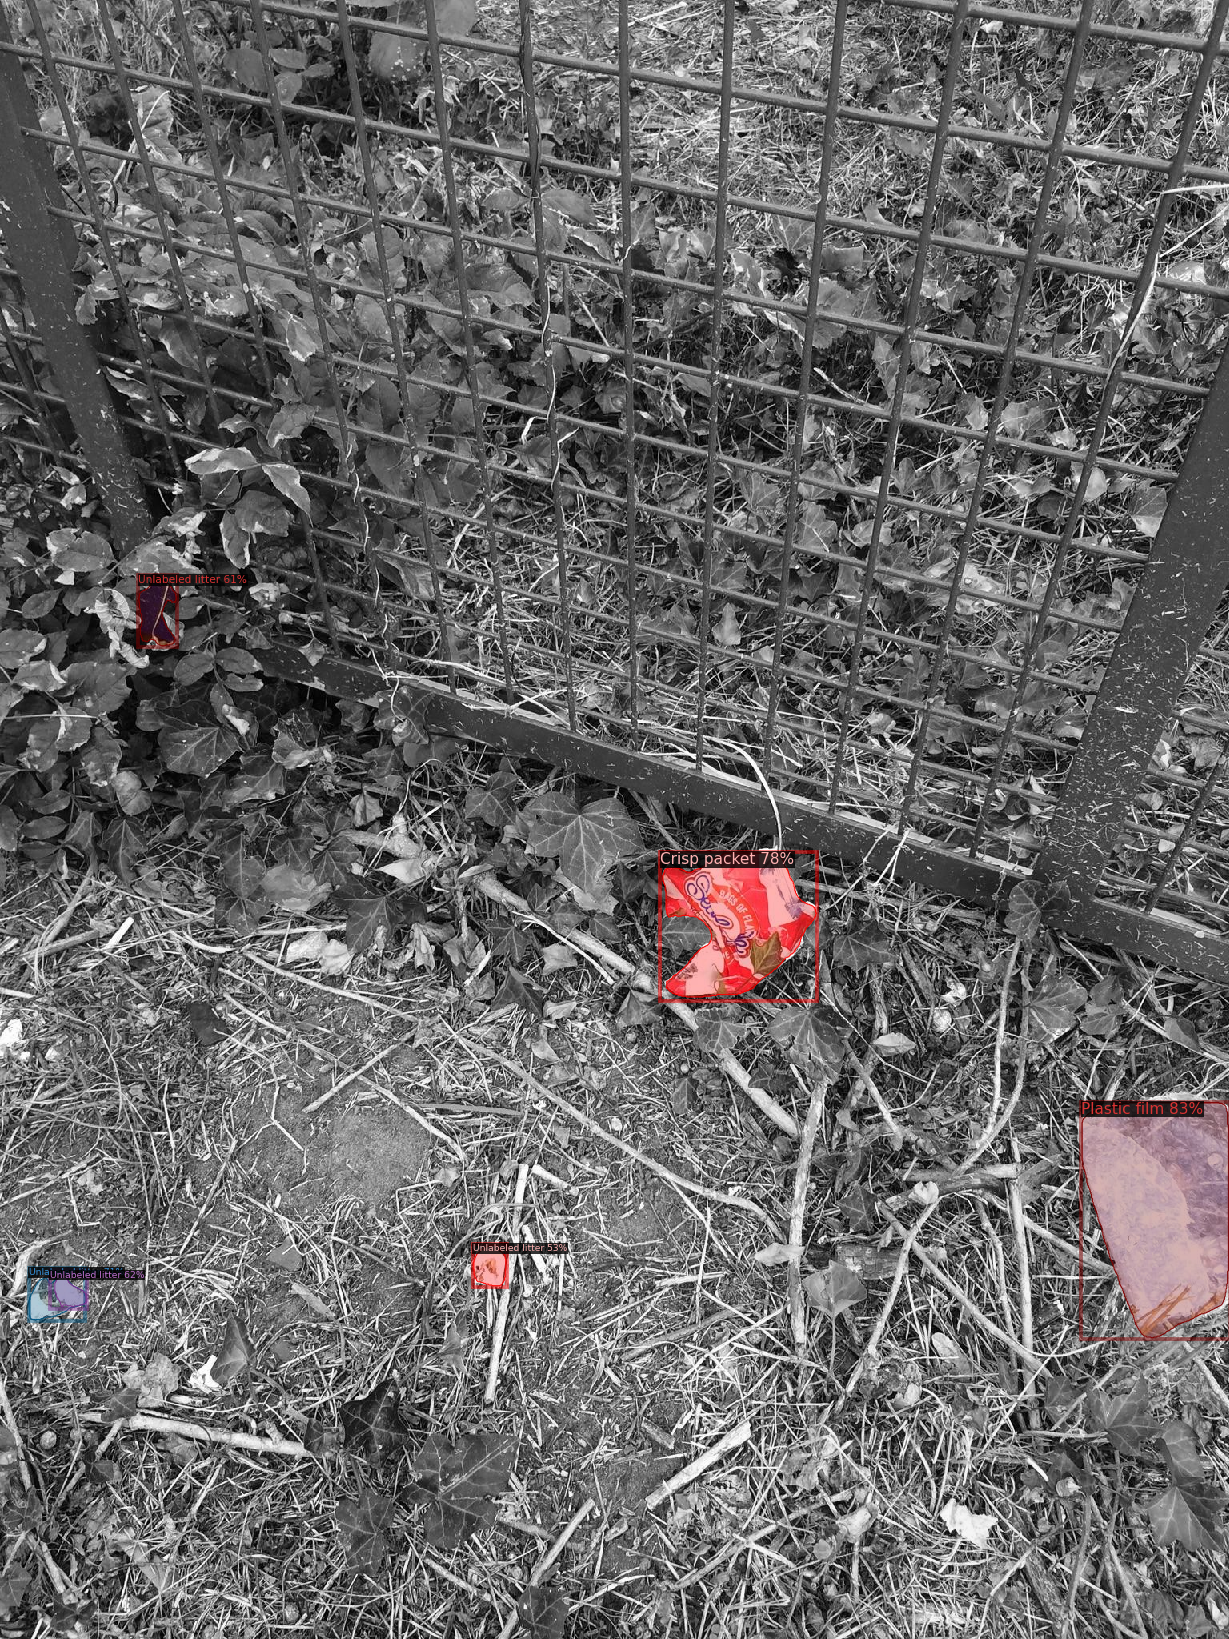

In [25]:
#
from detectron2.utils.visualizer import ColorMode
im = cv2.imread(test_image)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("taco_dataset_v4"),
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])